In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

In [107]:
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
#data1 = data1.drop(range(1935, 1963))
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
#min_y = min(g)
#max_y = max(g)
#for i in range(len(g)):
#    g[i] -= min_y
#    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)
print(len(trend))

1028


In [108]:
def func (x):
    y = (2.54*10**-4)*x**3 + (5.84*10**-2)*x**2 + (3.48 * 10)* x -(8.84 * 10)
    return y
g = func(np.array(g))
g

array([144317.03860176, 140844.2095499 , 167343.9417353 , ...,
       412749.85790277, 413068.64880801, 412780.70131044])

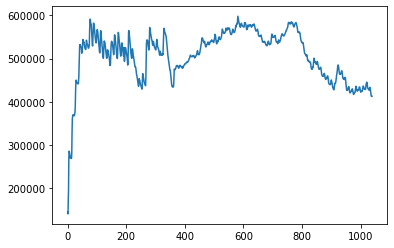

In [109]:
plt.plot(g)
g.tofile('v_t.csv', sep = ',')

In [5]:
def create_inout_sequences(input_data, tw = 180):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(trend)

In [6]:
import torch.nn as nn
from torch.nn import Sequential
import torch as tr
tr.manual_seed(0)

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = 128, #number of features coming out of the LSTM layer
            num_layers = 2, #number of LSTM layers
            batch_first = True,
            dropout = 0.2
            
        )
        self.out = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            
            nn.Linear(32,input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None) #initial h and c is 0
        out = self.out(r_out)
        return out
model = RNN(180)
loss_function = nn.MSELoss()
op = tr.optim.Adam(model.parameters(), lr=0.0001)
#op_2 = tr.optim.Adam(model.parameters(), lr = 0.0001)

In [17]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device) #looks for gpu if gpu is available and puts model into gpu for computation
repeats = 600 #decides how many times each piece of data is ran through the model
train_loss = []
test_loss = []
t_loss = 0
for repeat in range(repeats):
    model.train() #mode change into training
    #if repeats > 200:
        #op = op_2
    for seq, labels in train_inout_seq[:-1]: #enumerate returns data into data and index into index_train, for loop is a single test of all info
        #train_dataLoader includes 2 parts from the return, one is the target, other is data
        seq = [seq]
        labels = [labels]
        x = tr.Tensor(seq) #input
        y = tr.Tensor(labels) #label or target
        op.zero_grad() #clear previous derivative, otherwise would cause error
        pred = model(tr.unsqueeze(x, dim = 1)) #give the information (x) into the model, pred is the prediction of the model

        loss = loss_function(pred,tr.unsqueeze(y, 1)) # Compares prediction with actual target with cross entropy
        loss.backward() #pass the loss back (back propagation)
        op.step() #with the loss, can optimize the model
        train_loss.append(loss)

    seq, labels = train_inout_seq[-1]
    seq = [seq]
    labels = [labels]
    x = tr.Tensor(seq)
    y = tr.Tensor(labels)
    op.zero_grad()
    pred = model(tr.unsqueeze(x, dim = 1))
    t_loss = loss_function(pred, tr.unsqueeze(y, 1))
    test_loss.append(t_loss)

    print ("Epoch %d Loss: %f Test Loss: %f"%(repeat, loss, t_loss))



#% is a replacement, letter after decides format

Epoch 0 Loss: 0.073176 Test Loss: 0.073816
Epoch 1 Loss: 0.058990 Test Loss: 0.059499
Epoch 2 Loss: 0.064656 Test Loss: 0.065180
Epoch 3 Loss: 0.057297 Test Loss: 0.057988
Epoch 4 Loss: 0.054733 Test Loss: 0.055060
Epoch 5 Loss: 0.058732 Test Loss: 0.059362
Epoch 6 Loss: 0.059816 Test Loss: 0.060215
Epoch 7 Loss: 0.072400 Test Loss: 0.073230
Epoch 8 Loss: 0.059942 Test Loss: 0.060328
Epoch 9 Loss: 0.056791 Test Loss: 0.056890
Epoch 10 Loss: 0.085833 Test Loss: 0.086998
Epoch 11 Loss: 0.077739 Test Loss: 0.078458
Epoch 12 Loss: 0.062317 Test Loss: 0.062654
Epoch 13 Loss: 0.065650 Test Loss: 0.066755
Epoch 14 Loss: 0.064289 Test Loss: 0.065169
Epoch 15 Loss: 0.051620 Test Loss: 0.051734
Epoch 16 Loss: 0.037060 Test Loss: 0.037667
Epoch 17 Loss: 0.028207 Test Loss: 0.028721
Epoch 18 Loss: 0.022229 Test Loss: 0.022704
Epoch 19 Loss: 0.018105 Test Loss: 0.019554
Epoch 20 Loss: 0.014981 Test Loss: 0.015412
Epoch 21 Loss: 0.012705 Test Loss: 0.013220
Epoch 22 Loss: 0.011266 Test Loss: 0.01159

Epoch 185 Loss: 0.000723 Test Loss: 0.000980
Epoch 186 Loss: 0.000589 Test Loss: 0.000893
Epoch 187 Loss: 0.000645 Test Loss: 0.000972
Epoch 188 Loss: 0.000557 Test Loss: 0.001066
Epoch 189 Loss: 0.000806 Test Loss: 0.000994
Epoch 190 Loss: 0.000975 Test Loss: 0.001075
Epoch 191 Loss: 0.000579 Test Loss: 0.001106
Epoch 192 Loss: 0.000993 Test Loss: 0.000792
Epoch 193 Loss: 0.000558 Test Loss: 0.000781
Epoch 194 Loss: 0.000812 Test Loss: 0.001722
Epoch 195 Loss: 0.000662 Test Loss: 0.001093
Epoch 196 Loss: 0.001817 Test Loss: 0.001034
Epoch 197 Loss: 0.000627 Test Loss: 0.000785
Epoch 198 Loss: 0.000846 Test Loss: 0.000769
Epoch 199 Loss: 0.000545 Test Loss: 0.000762
Epoch 200 Loss: 0.000517 Test Loss: 0.000793
Epoch 201 Loss: 0.000575 Test Loss: 0.001583
Epoch 202 Loss: 0.000527 Test Loss: 0.000781
Epoch 203 Loss: 0.000721 Test Loss: 0.000731
Epoch 204 Loss: 0.000507 Test Loss: 0.000699
Epoch 205 Loss: 0.000554 Test Loss: 0.000707
Epoch 206 Loss: 0.000636 Test Loss: 0.000735
Epoch 207 

Epoch 368 Loss: 0.000312 Test Loss: 0.000456
Epoch 369 Loss: 0.000325 Test Loss: 0.000429
Epoch 370 Loss: 0.000353 Test Loss: 0.000493
Epoch 371 Loss: 0.000328 Test Loss: 0.000600
Epoch 372 Loss: 0.000434 Test Loss: 0.000470
Epoch 373 Loss: 0.000383 Test Loss: 0.000538
Epoch 374 Loss: 0.000459 Test Loss: 0.000959
Epoch 375 Loss: 0.000273 Test Loss: 0.000578
Epoch 376 Loss: 0.000333 Test Loss: 0.000537
Epoch 377 Loss: 0.000865 Test Loss: 0.000419
Epoch 378 Loss: 0.000337 Test Loss: 0.000531
Epoch 379 Loss: 0.000296 Test Loss: 0.000508
Epoch 380 Loss: 0.000799 Test Loss: 0.010779
Epoch 381 Loss: 0.000378 Test Loss: 0.000465
Epoch 382 Loss: 0.000286 Test Loss: 0.000417
Epoch 383 Loss: 0.000303 Test Loss: 0.000575
Epoch 384 Loss: 0.000280 Test Loss: 0.000444
Epoch 385 Loss: 0.000625 Test Loss: 0.000455
Epoch 386 Loss: 0.000311 Test Loss: 0.000453
Epoch 387 Loss: 0.000524 Test Loss: 0.000458
Epoch 388 Loss: 0.000274 Test Loss: 0.000424
Epoch 389 Loss: 0.000298 Test Loss: 0.000491
Epoch 390 

Epoch 551 Loss: 0.000290 Test Loss: 0.000473
Epoch 552 Loss: 0.000445 Test Loss: 0.000539
Epoch 553 Loss: 0.000366 Test Loss: 0.000403
Epoch 554 Loss: 0.000534 Test Loss: 0.000571
Epoch 555 Loss: 0.003060 Test Loss: 0.000597
Epoch 556 Loss: 0.000318 Test Loss: 0.000402
Epoch 557 Loss: 0.000273 Test Loss: 0.000483
Epoch 558 Loss: 0.000280 Test Loss: 0.000418
Epoch 559 Loss: 0.000356 Test Loss: 0.000448
Epoch 560 Loss: 0.000262 Test Loss: 0.000413
Epoch 561 Loss: 0.000251 Test Loss: 0.000410
Epoch 562 Loss: 0.000258 Test Loss: 0.000529
Epoch 563 Loss: 0.000250 Test Loss: 0.000384
Epoch 564 Loss: 0.000441 Test Loss: 0.000580
Epoch 565 Loss: 0.000329 Test Loss: 0.000444
Epoch 566 Loss: 0.000260 Test Loss: 0.000481
Epoch 567 Loss: 0.000279 Test Loss: 0.000416
Epoch 568 Loss: 0.000299 Test Loss: 0.000500
Epoch 569 Loss: 0.000330 Test Loss: 0.000419
Epoch 570 Loss: 0.000370 Test Loss: 0.000421
Epoch 571 Loss: 0.000321 Test Loss: 0.000398
Epoch 572 Loss: 0.000534 Test Loss: 0.000465
Epoch 573 

In [8]:
#tr.save(model, 'model_180_2')
model = tr.load('model_180')

tensor([[[7.3091e-01, 7.3716e-01, 7.5578e-01, 7.7365e-01, 7.7115e-01,
          7.2666e-01, 6.6292e-01, 6.0292e-01, 5.7305e-01, 5.4906e-01,
          5.5231e-01, 5.4256e-01, 5.4118e-01, 5.4456e-01, 5.8943e-01,
          6.1005e-01, 6.1592e-01, 5.9992e-01, 5.3693e-01, 4.9244e-01,
          4.6657e-01, 4.5957e-01, 4.6844e-01, 4.7632e-01, 5.0356e-01,
          4.9594e-01, 5.4143e-01, 5.5156e-01, 5.4718e-01, 4.9681e-01,
          4.2007e-01, 3.6583e-01, 3.4508e-01, 3.3183e-01, 3.2596e-01,
          3.2533e-01, 3.2008e-01, 3.2333e-01, 3.5808e-01, 4.0457e-01,
          4.4444e-01, 4.1257e-01, 3.7933e-01, 3.3308e-01, 2.7059e-01,
          2.4147e-01, 2.4072e-01, 2.0197e-01, 1.8385e-01, 1.7860e-01,
          2.3310e-01, 3.0096e-01, 3.5158e-01, 3.5921e-01, 3.5133e-01,
          3.7808e-01, 4.3407e-01, 4.9269e-01, 5.7243e-01, 6.0480e-01,
          6.6679e-01, 7.2703e-01, 8.1465e-01, 8.3152e-01, 8.1752e-01,
          7.7190e-01, 7.0341e-01, 6.4654e-01, 6.0230e-01, 6.0330e-01,
          6.1130e-01

Text(0, 0.5, 'Water Elevation (ft)')

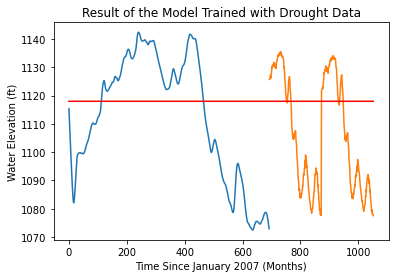

In [60]:
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2005))
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
tw = 180
g1 = g
z = g1[-tw:]
pred = []
z = [z]
z = tr.tensor(z, dtype = tr.float32)
z = tr.unsqueeze(z, dim = 1)
print(z)
for i in range(2):
    z = model(z)
    z = tr.squeeze(z)
    pred.append(z)
    z = z.tolist()
    g1.extend(z)
    z = g1[-tw:]
    z = [z]
    z = tr.tensor(z, dtype = tr.float32)
    z = tr.unsqueeze(z, dim = 1)
prev_x = []
for i in decomp.trend:
    if not np.isnan(i):
        prev_x.append(i * (max_y - min_y) + min_y)
final_2030 = []
for i in pred:
    for j in i:
        final_2030.append(((j * (max_y - min_y)) + min_y))
time_to = len(prev_x)+len(final_2030)
now = len(prev_x)
a_1118 = []
for i in range(0, time_to):
    a_1118.append(1118)
plt.plot(range(len(prev_x)),prev_x)
plt.plot(range(now, time_to), final_2030)
plt.plot(range(0, time_to), a_1118, color = 'r')
plt.title('Result of the Model Trained with Drought Data')
plt.xlabel('Time Since January 2007 (Months)')
plt.ylabel('Water Elevation (ft)')
#plt.xlim([600, 800])
#plt.savefig('result_problem3.pdf')

In [74]:
final_2030 = np.array(final_2030)
final_2030.tofile('final_pred.csv', sep = ',')

(1, 714)
357
357


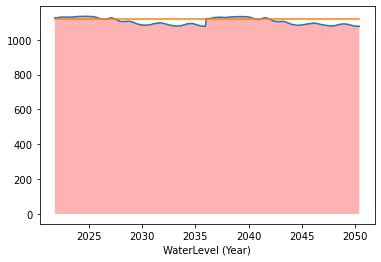

In [61]:
data = pd.read_csv('final_pred.csv', header = None)
data_np = data.to_numpy()
print(data_np.shape)
data_np=data_np.flatten()

a=[]
for i in range(0,data_np.size,2):
    a.append(float((data_np[i])[7:15]))
a=np.array(a)
print(a.size)
x=np.arange(2021.83,2050.416, 0.0802)
print(x.size)
plt.plot(x,a)
plt.xlabel('Time (Year)')
plt.xlabel('WaterLevel (Year)')
y1=np.zeros(357)
y1=y1+1118
plt.plot(x,y1)
plt.fill_between(x,y1,a, facecolor='w', alpha=1)
plt.fill_between(x,0,a, facecolor='r', alpha=0.3)

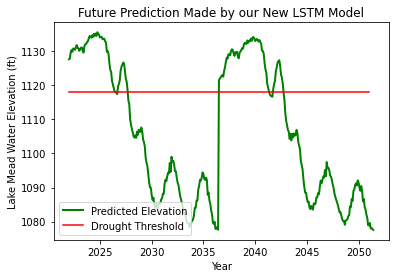

In [81]:
c = []
dt = final_2030.tolist()
del dt[0:3]
for i in np.arange(0, len(dt)/12):
    c.append(1118)

plt.plot(np.arange(2022, 2022 + len(dt)/12, 1/12), dt, linewidth = 2, color = 'g', label = 'Predicted Elevation')
plt.plot(np.arange(2022, 2022 + len(c)),c, color = 'r', label = 'Drought Threshold')
plt.legend(loc = 'lower left')
plt.xlabel("Year")
plt.ylabel("Lake Mead Water Elevation (ft)")
plt.title("Future Prediction Made by our New LSTM Model")
plt.savefig('problem_2345.pdf')

In [82]:
data = final_2030
data = data.tolist()
del data[0:3]

(240.0, 370.65)

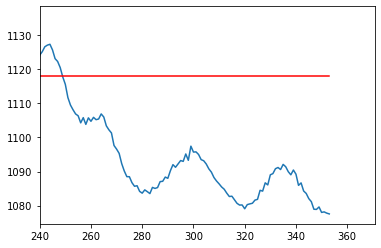

In [87]:
data2_1118 = []
for i in range(len(data)):
    data2_1118.append(1118)
plt.plot(data)
plt.plot(data2_1118, color = 'r')
plt.xlim(240)

In [88]:
#65
ind = 0
j = 239
for i in data[240:250]:
    j += 1
    if ind == 0 and i <= 1118:
        ind = j
ind
#2027 September 69, end 2036 June 174
#2042 September 249, to 2051 357 sept


249

In [89]:
249%12

9

In [53]:
def func (x):
    y = (2.54*10**-4)*x**3 + (5.84*10**-2)*x**2 + (3.48 * 10)* x -(8.84 * 10)
    return y
threshold = 1118 - 895
threshold = func(threshold)

vol_1 = np.array(data[69:174])
vol_2 = np.array(data[242:357])
for i in range(len(vol_1)):
    vol_1[i] -= 895
for i in range(len(vol_2)):
    vol_2[i] -= 895
vol_1 = func(vol_1)
vol_2 = func(vol_2)

for i in range(len(vol_1)):
    vol_1[i] = threshold - vol_1[i]
for i in range(len(vol_2)):
    vol_2[i] = threshold - vol_2[i]


10039771.656889042


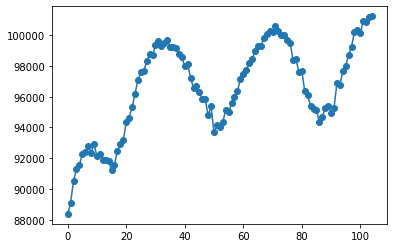

In [55]:
y = range(len(vol_1))
plt.scatter(y, vol_1)

from scipy.interpolate import InterpolatedUnivariateSpline
spl = InterpolatedUnivariateSpline(y, vol_1)
plt.plot(y, spl(y))
print(spl.integral(0, len(vol_1)-1))

271954.2437855401


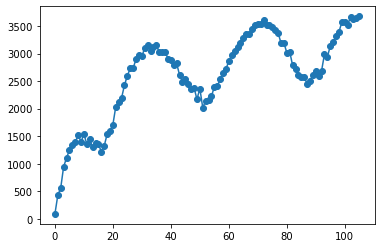

In [127]:
y = range(len(vol_2))
plt.scatter(y, vol_2)
spl_2 = InterpolatedUnivariateSpline(y, vol_2)
plt.plot(y, spl_2(y))
print(spl_2.integral(0, len(vol_2)-1))

In [20]:
a = np.zeros((24, 19, 2))
#a = np.load('sensitivity.npy', allow_pickle = True)
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
k = -1
for i in range(24, 49):
    train_inout_seq = create_inout_sequences(trend, i)
    for j in np.arange(0.0001, 0.0014, 0.00005):
        model = RNN(i+3)
        k += 1
        op = tr.optim.Adam(model.parameters(), lr=j)
        model = model.to(device) #looks for gpu if gpu is available and puts model into gpu for computation
        repeats = 600 #decides how many times each piece of data is ran through the model
        train_loss = []
        test_loss = []
        t_loss = 0
        loss = 0
        print('yes')
        for repeat in range(repeats):
            if a[i-24][k][0] != 0: 
                continue
                print('skip')
            model.train() #mode change into training
            #if repeats > 200:
                #op = op_2
            for seq, labels in train_inout_seq[:-1]: #enumerate returns data into data and index into index_train, for loop is a single test of all info
                #train_dataLoader includes 2 parts from the return, one is the target, other is data
                seq = [seq]
                labels = [labels]
                x = tr.Tensor(seq) #input
                y = tr.Tensor(labels) #label or target
                op.zero_grad() #clear previous derivative, otherwise would cause error
                pred = model(tr.unsqueeze(x, dim = 1)) #give the information (x) into the model, pred is the prediction of the model

                loss = loss_function(pred,tr.unsqueeze(y, 1)) # Compares prediction with actual target with cross entropy
                loss.backward() #pass the loss back (back propagation)
                op.step() #with the loss, can optimize the model
                train_loss.append(loss)

            seq, labels = train_inout_seq[-1]
            seq = [seq]
            labels = [labels]
            x = tr.Tensor(seq)
            y = tr.Tensor(labels)
            op.zero_grad()
            pred = model(tr.unsqueeze(x, dim = 1))
            t_loss = loss_function(pred, tr.unsqueeze(y, 1))
            test_loss.append(t_loss)
        a[i-24][k][0] = t_loss
        a[i-24][k][1] = loss
        np.save('sensitivity2', a, allow_pickle = True)
        
    #print ("Epoch %d Loss: %f Test Loss: %f"%(repeat, loss, t_loss))



#% is a replacement, letter after decides format

yes


KeyboardInterrupt: 

In [93]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2007))
data1 = data1.drop(2021)
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)

In [94]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(trend)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.491062
p-value: 0.537928
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


In [115]:
import statsmodels.api as sm
model=sm.tsa.ARIMA(endog=trend,order=(3, 1, 1))
results=model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  155
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 815.471
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 14 Nov 2021   AIC                          -1618.942
Time:                        20:41:32   BIC                          -1600.682
Sample:                             1   HQIC                         -1611.525
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.004     -1.063      0.288      -0.012       0.004
ar.L1.D.y      1.3637      0.074     18.329      0.000       1.218       1.509
ar.L2.D.y     -0.0222      0.135     -0.165      0.8

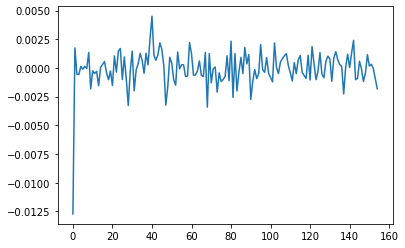

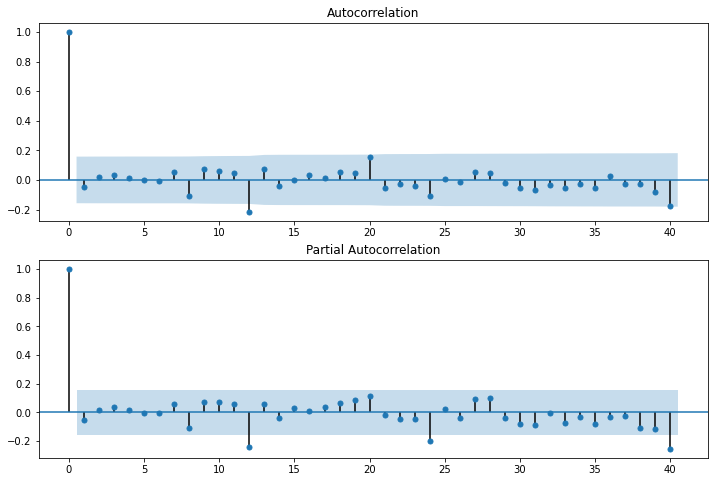

In [120]:
plt.plot(range(len(results.resid)), results.resid)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=40, ax=ax2)
plt.savefig('correlation.pdf')

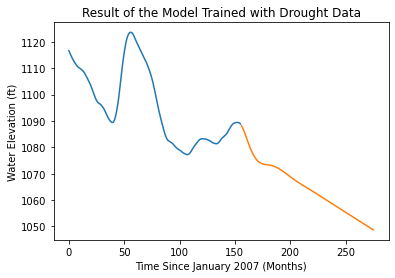

In [121]:
forecast,std,conf=results.forecast(120)
prev_x = []
for i in decomp.trend:
    if not np.isnan(i):
        prev_x.append(i * (max_y - min_y) + min_y)
final_2030 = []
for i in forecast:
    final_2030.append(i * (max_y - min_y) + min_y)
time_to = len(prev_x)+len(final_2030)
now = len(prev_x)
plt.plot(range(len(prev_x)),prev_x)
plt.plot(range(now, time_to), final_2030)
plt.title('Result of the Model Trained with Drought Data')
plt.xlabel('Time Since January 2007 (Months)')
plt.ylabel('Water Elevation (ft)')
#plt.ylim([1070, 1150])
#plt.plot(forecast)
plt.savefig('result_drought.pdf')

In [84]:
res, res_std, res_conf = results.forecast(360)
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2006))
data1 = data1.drop(2021)
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)
res[0] += trend[-1]
for i in range(len(res[1:])):
    res[i] += res[i-1]

In [85]:
res

array([ 1.99419219e-01,  1.87180669e-01,  1.72734641e-01,  1.56466306e-01,
        1.38692415e-01,  1.19673447e-01,  9.96236112e-02,  7.87190619e-02,
        5.71046612e-02,  3.48995372e-02,  1.22016555e-02, -1.09084211e-02,
       -3.43644415e-02, -5.81119238e-02, -8.21060643e-02, -1.06310018e-01,
       -1.30693487e-01, -1.55231553e-01, -1.79903727e-01, -2.04693157e-01,
       -2.29585987e-01, -2.54570822e-01, -2.79638289e-01, -3.04780683e-01,
       -3.29991667e-01, -3.55266028e-01, -3.80599482e-01, -4.05988503e-01,
       -4.31430193e-01, -4.56922170e-01, -4.82462472e-01, -5.08049488e-01,
       -5.33681892e-01, -5.59358594e-01, -5.85078699e-01, -6.10841468e-01,
       -6.36646296e-01, -6.62492683e-01, -6.88380221e-01, -7.14308572e-01,
       -7.40277458e-01, -7.66286652e-01, -7.92335966e-01, -8.18425246e-01,
       -8.44554365e-01, -8.70723220e-01, -8.96931723e-01, -9.23179805e-01,
       -9.49467408e-01, -9.75794483e-01, -1.00216099e+00, -1.02856690e+00,
       -1.05501219e+00, -

In [86]:
res, res_std, res_conf = results.forecast(360)
res

array([-0.00956269, -0.01223855, -0.01444603, -0.01626833, -0.01777389,
       -0.01901897, -0.02004984, -0.02090455, -0.0216144 , -0.02220512,
       -0.02269788, -0.02311008, -0.02345602, -0.02374748, -0.02399414,
       -0.02420395, -0.02438347, -0.02453807, -0.02467217, -0.02478943,
       -0.02489283, -0.02498483, -0.02506747, -0.02514239, -0.02521098,
       -0.02527436, -0.02533345, -0.02538902, -0.02544169, -0.02549198,
       -0.0255403 , -0.02558702, -0.0256324 , -0.0256767 , -0.0257201 ,
       -0.02576277, -0.02580483, -0.02584639, -0.02588754, -0.02592835,
       -0.02596889, -0.02600919, -0.02604931, -0.02608928, -0.02612912,
       -0.02616885, -0.0262085 , -0.02624808, -0.0262876 , -0.02632708,
       -0.02636651, -0.02640591, -0.02644529, -0.02648464, -0.02652397,
       -0.02656329, -0.0266026 , -0.0266419 , -0.02668119, -0.02672048,
       -0.02675975, -0.02679903, -0.0268383 , -0.02687756, -0.02691683,
       -0.02695609, -0.02699535, -0.02703461, -0.02707386, -0.02

In [ ]:
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(4, 1)
ax[0].plot(g)
ax[1].plot(decomp.trend)
ax[2].plot(decomp.seasonal)
ax[3].scatter(x = range(len(decomp.trend)), y= decomp.resid)
ax[0].set_ylabel('Observed', size = 15)
ax[1].set_ylabel('Trend', size = 15)
ax[2].set_ylabel('Seasonal', size = 15)
ax[3].set_ylabel('Residue', size = 15)
ax[3].set_xlabel('Time After January 1941 (Months)', size = 15)
#ax[1].tick_params(labelsize=20)
plt.savefig('decomp.pdf')

In [18]:
a = [0,1]
a.extend([2, 3])
a

[0, 1, 2, 3]